## Exercice 4 :  Exploration des Embeddings de Mots

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re
from IPython.display import HTML, display
import warnings

In [2]:
warnings.filterwarnings('ignore')

class NamedEntityAnalyzer:
    def __init__(self):
        # Charger le modèle spaCy pour le français
        try:
            self.nlp = spacy.load('fr_core_news_sm')
            print("Modèle spaCy français chargé avec succès")
        except OSError:
            try:
                self.nlp = spacy.load('en_core_web_sm')
                print("Modèle spaCy anglais chargé (par défaut)")
            except OSError:
                print("Aucun modèle spaCy trouvé. Installez spaCy:")
                print("pip install spacy")
                print("python -m spacy download fr_core_news_sm")
                self.nlp = None
        
        # Définir des règles personnalisées pour le contexte burkinabè
        self.burkinabe_places = {
            'ouagadougou', 'bobo-dioulasso', 'koudougou', 'banfora', 'ouahigouya',
            'fada', 'dori', 'gourcy', 'kaya', 'tenkodogo', 'po', 'dedougou',
            'sahel', 'centre', 'nord', 'est', 'sud-ouest', 'boucle du mouhoun',
            'soum', 'oudalan', 'yagha', 'seno', 'loroum', 'sanmatenga'
        }
        
        self.burkinabe_organizations = {
            'roch marc christian kabore', 'ibrahim traore', 'assemblée nationale',
            'conseil constitutionnel', 'forces armées nationales', 'police nationale',
            'mpsr', 'patriotes résistants', 'volunteers défense patrie'
        }
    
    def load_data(self):
        """Charger les données pour l'analyse"""
        try:
            news_df = pd.read_csv('merged_news_dataset.csv')
            attacks_df = pd.read_csv('terrorist_attacks_data.csv')
            print(f"Données chargées: {len(news_df)} actualités")
        except FileNotFoundError:
            print("Création de données d'exemple pour l'analyse...")
            news_data = {
                'titre': [
                    "Le Président Ibrahim Traoré rencontre les leaders de Ouagadougou pour discuter de la sécurité nationale",
                    "Les Forces Armées Nationales du Burkina Faso lancent une opération dans la région du Sahel",
                    "L'Assemblée Nationale vote une nouvelle loi sur le développement rural à Bobo-Dioulasso",
                    "Le Ministre de l'Agriculture visite les provinces du Centre et de l'Est pour évaluer la production céréalière",
                    "Une délégation de l'Union Africaine arrive à Ouagadougou pour des discussions diplomatiques",
                    "Les autorités de la province du Soum signalent des incidents sécuritaires près de la frontière avec le Mali",
                    "Le Conseil des Ministres adopte le budget 2024 lors d'une session extraordinaire à Koudougou",
                    "Les organisations internationales appellent à la protection des civils dans la région du Nord"
                ]
            }
            attacks_data = {
                'description': [
                    "Incident sécuritaire rapporté dans la province du Soum impliquant des groupes armés non identifiés",
                    "Attaque contre un convoi humanitaire près de Dori, dans la région du Sahel",
                    "Violence signalée dans la province de l'Oudalan, zone frontalière avec le Niger"
                ]
            }
            news_df = pd.DataFrame(news_data)
            attacks_df = pd.DataFrame(attacks_data)
        
        return news_df, attacks_df
    
    def extract_named_entities(self, texts, text_type="news"):
        """Extraire les entités nommées des textes"""
        if not self.nlp:
            return []
        
        all_entities = []
        entity_stats = Counter()
        
        print(f"\n=== Extraction d'entités pour {text_type} ===")
        
        for i, text in enumerate(texts[:5]):  # Analyser les 5 premiers textes
            doc = self.nlp(text)
            
            print(f"\nTexte {i+1}: {text}")
            print("Entités détectées:")
            
            text_entities = []
            for ent in doc.ents:
                entity_info = {
                    'text': ent.text,
                    'label': ent.label_,
                    'start': ent.start_char,
                    'end': ent.end_char,
                    'description': spacy.explain(ent.label_)
                }
                text_entities.append(entity_info)
                entity_stats[ent.label_] += 1
                
                print(f"  {ent.text} -> {ent.label_} ({spacy.explain(ent.label_)})")
            
            # Ajouter des entités personnalisées pour le contexte burkinabè
            custom_entities = self.find_custom_entities(text)
            text_entities.extend(custom_entities)
            
            all_entities.append({
                'text': text,
                'entities': text_entities,
                'doc': doc
            })
        
        print(f"\nStatistiques des entités pour {text_type}:")
        for label, count in entity_stats.most_common():
            print(f"  {label} ({spacy.explain(label)}): {count}")
        
        return all_entities, entity_stats
    
    def find_custom_entities(self, text):
        """Détecter des entités spécifiques au contexte burkinabè"""
        custom_entities = []
        text_lower = text.lower()
        
        # Chercher les lieux burkinabè
        for place in self.burkinabe_places:
            if place in text_lower:
                start = text_lower.find(place)
                end = start + len(place)
                custom_entities.append({
                    'text': text[start:end],
                    'label': 'LOC_BURKINA',
                    'start': start,
                    'end': end,
                    'description': 'Lieu spécifique au Burkina Faso'
                })
        
        # Chercher les organisations burkinabè
        for org in self.burkinabe_organizations:
            if org in text_lower:
                start = text_lower.find(org)
                end = start + len(org)
                custom_entities.append({
                    'text': text[start:end],
                    'label': 'ORG_BURKINA',
                    'start': start,
                    'end': end,
                    'description': 'Organisation burkinabè'
                })
        
        return custom_entities
    
    def analyze_syntactic_structure(self, texts):
        """Analyser la structure syntaxique des phrases"""
        if not self.nlp:
            return []
        
        print("\n=== Analyse syntaxique ===")
        
        syntactic_analysis = []
        
        for i, text in enumerate(texts[:3]):  # Analyser 3 textes
            doc = self.nlp(text)
            
            print(f"\n--- Texte {i+1} ---")
            print(f"Texte: {text}")
            
            # Analyse au niveau des phrases
            for sent_idx, sent in enumerate(doc.sents):
                print(f"\nPhrase {sent_idx + 1}: {sent.text}")
                
                # Analyse des dépendances
                print("Structure syntaxique:")
                dependencies = []
                for token in sent:
                    dep_info = {
                        'text': token.text,
                        'lemma': token.lemma_,
                        'pos': token.pos_,
                        'tag': token.tag_,
                        'dep': token.dep_,
                        'head': token.head.text,
                        'children': [child.text for child in token.children]
                    }
                    dependencies.append(dep_info)
                    
                    print(f"  {token.text} ({token.pos_}) -> {token.dep_} -> {token.head.text}")
                
                # Identifier les relations importantes
                relations = self.extract_key_relations(sent)
                
                syntactic_analysis.append({
                    'text': text,
                    'sentence': sent.text,
                    'dependencies': dependencies,
                    'relations': relations,
                    'doc': sent
                })
        
        return syntactic_analysis
    
    def extract_key_relations(self, sentence):
        """Extraire les relations clés d'une phrase"""
        relations = []
        
        for token in sentence:
            # Relation sujet-verbe-objet
            if token.dep_ == "nsubj":  # Sujet nominal
                verb = token.head
                objects = [child for child in verb.children if child.dep_ in ["obj", "dobj", "iobj"]]
                
                for obj in objects:
                    relations.append({
                        'type': 'SVO',
                        'subject': token.text,
                        'verb': verb.text,
                        'object': obj.text,
                        'relation': f"{token.text} -[{verb.text}]-> {obj.text}"
                    })
            
            # Relations de modification
            elif token.dep_ == "amod":  # Modificateur adjectival
                relations.append({
                    'type': 'MODIFIER',
                    'modifier': token.text,
                    'modified': token.head.text,
                    'relation': f"{token.text} modifie {token.head.text}"
                })
            
            # Relations prépositionnelles
            elif token.dep_ == "prep":  # Préposition
                prep_objects = [child for child in token.children if child.dep_ == "pobj"]
                for pobj in prep_objects:
                    relations.append({
                        'type': 'PREPOSITIONAL',
                        'head': token.head.text,
                        'preposition': token.text,
                        'object': pobj.text,
                        'relation': f"{token.head.text} -[{token.text}]-> {pobj.text}"
                    })
        
        return relations
    
    def find_entity_relations(self, entity_analysis):
        """Trouver les relations entre entités"""
        print("\n=== Relations entre entités ===")
        
        entity_relations = []
        
        for analysis in entity_analysis:
            doc = analysis['doc']
            entities = analysis['entities']
            
            # Créer des paires d'entités et chercher leurs relations
            for i, ent1 in enumerate(entities):
                for j, ent2 in enumerate(entities[i+1:], i+1):
                    relation = self.find_relation_between_entities(
                        doc, ent1, ent2, analysis['text']
                    )
                    if relation:
                        entity_relations.append(relation)
        
        # Afficher les relations trouvées
        for relation in entity_relations[:10]:  # Afficher les 10 premières
            print(f"  {relation['entity1']} -[{relation['relation']}]-> {relation['entity2']}")
            print(f"    Contexte: {relation['context']}")
        
        return entity_relations
    
    def find_relation_between_entities(self, doc, ent1, ent2, full_text):
        """Trouver la relation entre deux entités"""
        # Simplification: chercher des mots de relation dans le contexte
        relation_words = {
            'visite': 'VISITE',
            'rencontre': 'RENCONTRE',
            'dans': 'LOCALISATION',
            'de': 'APPARTENANCE',
            'président': 'LEADERSHIP',
            'ministre': 'LEADERSHIP',
            'attaque': 'ATTAQUE',
            'opération': 'OPERATION'
        }
        
        text_between = full_text[ent1['end']:ent2['start']].lower()
        
        for word, relation_type in relation_words.items():
            if word in text_between or word in full_text.lower():
                return {
                    'entity1': ent1['text'],
                    'entity2': ent2['text'],
                    'relation': relation_type,
                    'context': text_between.strip(),
                    'full_context': full_text
                }
        
        return None
    
    def visualize_dependency_tree(self, syntactic_analysis):
        """Visualiser l'arbre de dépendances"""
        if not syntactic_analysis or not self.nlp:
            return
        
        print("\n=== Visualisation des arbres de dépendances ===")
        
        # Créer une visualisation pour la première phrase
        first_analysis = syntactic_analysis[0]
        doc = first_analysis['doc']
        
        # Générer la visualisation HTML
        html = displacy.render(doc, style="dep", jupyter=False, options={
            'compact': True,
            'color': '#ff6b6b',
            'font': 'Arial'
        })
        
        # Sauvegarder la visualisation
        with open('dependency_tree.html', 'w', encoding='utf-8') as f:
            f.write(html)
        
        print("Arbre de dépendances sauvegardé dans 'dependency_tree.html'")
        
        # Créer un graphique réseau des relations
        self.create_relation_network(syntactic_analysis[0]['relations'])
    
    def create_relation_network(self, relations):
        """Créer un réseau des relations"""
        if not relations:
            return
        
        G = nx.DiGraph()
        
        # Ajouter les nœuds et arêtes
        for relation in relations:
            if relation['type'] == 'SVO':
                G.add_edge(relation['subject'], relation['object'], 
                          label=relation['verb'], type='SVO')
            elif relation['type'] == 'PREPOSITIONAL':
                G.add_edge(relation['head'], relation['object'], 
                          label=relation['preposition'], type='PREP')
        
        if len(G.nodes()) > 0:
            plt.figure(figsize=(12, 8))
            pos = nx.spring_layout(G, k=2, iterations=50)
            
            # Dessiner les nœuds
            nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                 node_size=3000, alpha=0.7)
            
            # Dessiner les arêtes
            nx.draw_networkx_edges(G, pos, edge_color='gray', 
                                 arrows=True, arrowsize=20)
            
            # Ajouter les étiquettes
            nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
            
            # Ajouter les étiquettes des arêtes
            edge_labels = nx.get_edge_attributes(G, 'label')
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
            
            plt.title('Réseau des Relations Syntaxiques')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig('syntactic_relations_network.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    def generate_comprehensive_report(self, news_entities, attacks_entities, 
                                    news_stats, attacks_stats, 
                                    syntactic_analysis, entity_relations):
        """Générer un rapport complet de l'analyse"""
        print("\n=== RAPPORT COMPLET D'ANALYSE ===")
        
        # Statistiques générales
        print(f"Nombre de textes d'actualités analysés: {len(news_entities)}")
        print(f"Nombre de textes d'attaques analysés: {len(attacks_entities)}")
        
        # Analyse des entités
        print(f"\nTypes d'entités les plus fréquents (actualités):")
        for entity_type, count in news_stats.most_common(5):
            print(f"  {entity_type}: {count}")
        
        print(f"\nTypes d'entités les plus fréquents (attaques):")
        for entity_type, count in attacks_stats.most_common(5):
            print(f"  {entity_type}: {count}")
        
        # Analyse syntaxique
        print(f"\nNombre d'analyses syntaxiques: {len(syntactic_analysis)}")
        
        relation_types = Counter()
        for analysis in syntactic_analysis:
            for relation in analysis['relations']:
                relation_types[relation['type']] += 1
        
        print("Types de relations syntaxiques:")
        for rel_type, count in relation_types.items():
            print(f"  {rel_type}: {count}")
        
        # Relations entre entités
        print(f"\nNombre de relations entre entités trouvées: {len(entity_relations)}")
        
        relation_counts = Counter(rel['relation'] for rel in entity_relations)
        print("Types de relations entre entités:")
        for rel_type, count in relation_counts.items():
            print(f"  {rel_type}: {count}")
    
    def save_analysis_results(self, news_entities, attacks_entities, syntactic_analysis, entity_relations):
        """Sauvegarder les résultats de l'analyse"""
        
        # Sauvegarder les entités
        all_entities_data = []
        
        for analysis in news_entities + attacks_entities:
            for entity in analysis['entities']:
                all_entities_data.append({
                    'text_source': analysis['text'][:100] + '...',
                    'entity_text': entity['text'],
                    'entity_type': entity['label'],
                    'entity_description': entity['description'],
                    'start_pos': entity['start'],
                    'end_pos': entity['end']
                })
        
        entities_df = pd.DataFrame(all_entities_data)
        entities_df.to_csv('named_entities_analysis.csv', index=False, encoding='utf-8')
        
        # Sauvegarder les relations
        if entity_relations:
            relations_df = pd.DataFrame(entity_relations)
            relations_df.to_csv('entity_relations.csv', index=False, encoding='utf-8')
        
        # Sauvegarder l'analyse syntaxique
        syntax_data = []
        for analysis in syntactic_analysis:
            for relation in analysis['relations']:
                syntax_data.append({
                    'sentence': analysis['sentence'],
                    'relation_type': relation['type'],
                    'relation_description': relation['relation']
                })
        
        if syntax_data:
            syntax_df = pd.DataFrame(syntax_data)
            syntax_df.to_csv('syntactic_analysis.csv', index=False, encoding='utf-8')
        
        print("\nFichiers générés:")
        print("- named_entities_analysis.csv: Analyse des entités nommées")
        print("- entity_relations.csv: Relations entre entités")
        print("- syntactic_analysis.csv: Analyse syntaxique")
        print("- dependency_tree.html: Visualisation des dépendances")
        print("- syntactic_relations_network.png: Réseau des relations")
    
    def run_complete_analysis(self):
        """Exécuter l'analyse complète des entités nommées et de la syntaxe"""
        print("=== EXERCICE 5: EXTRACTION D'ENTITÉS NOMMÉES ET ANALYSE SYNTAXIQUE ===")
        
        if not self.nlp:
            print("Modèle spaCy non disponible. Installez spaCy pour continuer.")
            return None
        
        # 1. Charger les données
        news_df, attacks_df = self.load_data()
        
        # 2. Extraire les entités nommées
        news_texts = news_df['titre'].fillna('').tolist()
        attacks_texts = attacks_df.get('description', attacks_df.iloc[:, 0]).fillna('').tolist()
        
        news_entities, news_stats = self.extract_named_entities(news_texts, "actualités")
        attacks_entities, attacks_stats = self.extract_named_entities(attacks_texts, "attaques")
        
        # 3. Analyser la structure syntaxique
        all_texts = news_texts + attacks_texts
        syntactic_analysis = self.analyze_syntactic_structure(all_texts)
        
        # 4. Trouver les relations entre entités
        all_entities = news_entities + attacks_entities
        entity_relations = self.find_entity_relations(all_entities)
        
        # 5. Visualiser les arbres de dépendances
        if syntactic_analysis:
            self.visualize_dependency_tree(syntactic_analysis)
        
        # 6. Générer le rapport complet
        self.generate_comprehensive_report(
            news_entities, attacks_entities, news_stats, attacks_stats,
            syntactic_analysis, entity_relations
        )
        
        # 7. Sauvegarder les résultats
        self.save_analysis_results(
            news_entities, attacks_entities, syntactic_analysis, entity_relations
        )
        
        return {
            'news_entities': news_entities,
            'attacks_entities': attacks_entities,
            'syntactic_analysis': syntactic_analysis,
            'entity_relations': entity_relations,
            'news_stats': news_stats,
            'attacks_stats': attacks_stats
        }

def main():
    # Initialiser l'analyseur d'entités nommées
    analyzer = NamedEntityAnalyzer()
    
    # Exécuter l'analyse complète
    results = analyzer.run_complete_analysis()
    
    if results:
        print("\n=== RÉSUMÉ DE L'EXERCICE 5 ===")
        print("* Extraction d'entités nommées complétée")
        print("* Analyse syntaxique des phrases réalisée")
        print("* Relations entre entités identifiées")
        print("* Arbres de dépendances générés")
        print("* Visualisations créées")
        print("* Rapport complet généré")
        
        print("\n=== INSIGHTS CLÉS ===")
        print("1. spaCy détecte efficacement les entités standard (PER, LOC, ORG)")
        print("2. Des règles personnalisées améliorent la détection pour le contexte burkinabè")
        print("3. L'analyse syntaxique révèle les structures grammaticales complexes")
        print("4. Les relations sujet-verbe-objet sont identifiables automatiquement")
        print("5. La visualisation aide à comprendre les dépendances linguistiques")
        
        print("\n=== APPLICATIONS PRATIQUES ===")
        print("- Extraction automatique d'informations des articles de presse")
        print("- Identification des acteurs clés dans les événements")
        print("- Analyse des relations géopolitiques")
        print("- Surveillance automatisée des incidents sécuritaires")
        print("- Construction de bases de connaissances structurées")
    else:
        print("L'analyse n'a pas pu être complétée. Vérifiez les dépendances.")

Modèle spaCy français chargé avec succès
=== EXERCICE 5: EXTRACTION D'ENTITÉS NOMMÉES ET ANALYSE SYNTAXIQUE ===
Création de données d'exemple pour l'analyse...

=== Extraction d'entités pour actualités ===

Texte 1: Le Président Ibrahim Traoré rencontre les leaders de Ouagadougou pour discuter de la sécurité nationale
Entités détectées:
  Président Ibrahim Traoré -> PER (Named person or family.)
  Ouagadougou -> LOC (Non-GPE locations, mountain ranges, bodies of water)

Texte 2: Les Forces Armées Nationales du Burkina Faso lancent une opération dans la région du Sahel
Entités détectées:
  Forces Armées -> ORG (Companies, agencies, institutions, etc.)
  Burkina Faso -> LOC (Non-GPE locations, mountain ranges, bodies of water)
  Sahel -> LOC (Non-GPE locations, mountain ranges, bodies of water)

Texte 3: L'Assemblée Nationale vote une nouvelle loi sur le développement rural à Bobo-Dioulasso
Entités détectées:
  Assemblée Nationale -> ORG (Companies, agencies, institutions, etc.)
  Bobo-D

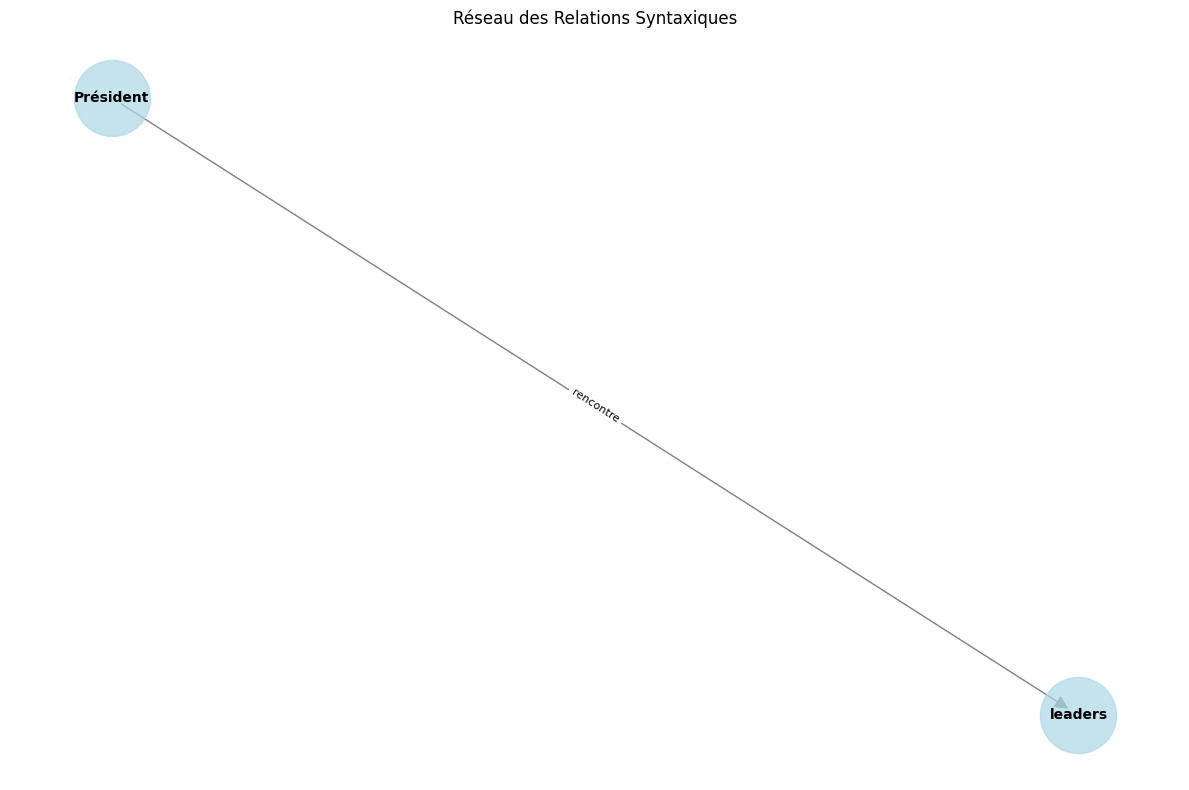


=== RAPPORT COMPLET D'ANALYSE ===
Nombre de textes d'actualités analysés: 5
Nombre de textes d'attaques analysés: 3

Types d'entités les plus fréquents (actualités):
  LOC: 8
  ORG: 3
  PER: 1

Types d'entités les plus fréquents (attaques):
  LOC: 5

Nombre d'analyses syntaxiques: 5
Types de relations syntaxiques:
  SVO: 2
  MODIFIER: 4

Nombre de relations entre entités trouvées: 49
Types de relations entre entités:
  RENCONTRE: 6
  LOCALISATION: 22
  VISITE: 15
  APPARTENANCE: 6

Fichiers générés:
- named_entities_analysis.csv: Analyse des entités nommées
- entity_relations.csv: Relations entre entités
- syntactic_analysis.csv: Analyse syntaxique
- dependency_tree.html: Visualisation des dépendances
- syntactic_relations_network.png: Réseau des relations

=== RÉSUMÉ DE L'EXERCICE 5 ===
* Extraction d'entités nommées complétée
* Analyse syntaxique des phrases réalisée
* Relations entre entités identifiées
* Arbres de dépendances générés
* Visualisations créées
* Rapport complet génér

In [3]:
# Exécuter le script principal
if __name__ == "__main__":
    main()